Installiamo la libreria Transformers, libreria open source sviluppata da Hugging Face. Questa libreria è utile per l'implementazione di modelli di trasformatori pre-addestrati

In [1]:
!pip install transformers

In [2]:
import pandas as pd
import sklearn
from google.colab import drive
import nltk
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer

nltk.download('punkt')
nltk.download('stopwords')

drive.mount('/content/gdrive')
root = "/content/gdrive/MyDrive/Colab Notebooks/torch/"
df = pd.read_csv(root+"data/subtaskA_train.csv")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/gdrive


Instaziamo gli iperparametri. Molti degli iperparametri utilizzati sono stati scelti come vedremo successivamente, grazie all'utilizzo della grid search.
Il language model utilizzato è invece xlm-roberta-base. Il motivo di questa scelta è legato alla struttura del dataset. Di fatti, se pur il dataset è un dataset in lingua italiana, contiene alcune parole o frasi in inglese il che ci ha portato ad una scelta di Roberta. Roberta è un modello multilingue, che riconosce anche le emoji, presenti nel nostro dataset

In [51]:
hyperparameters = {
  "epochs": 1000,
  "learning_rate": 2e-6,
  "batch_size": 32,
  "dropout": 0.3,
  "stopwords": True,
  "h_dim": 512,
  "num_layer_hidden": 0,
  "patience": 350,
  "min_delta": 0.08,
  "max_seq_length": 512,
  "language_model": "xlm-roberta-base"
}

# Data Pre-processing

## Mantenimento Emoji più frequenti



Questo blocco si occupa di gestire ed estrarre le emoji più comuni da ciascun commento, identificando e mantenendo le tre emoji più frequenti.
Il codice inizialmente identifica le emoji più frequenti in tutto il dataset di commenti tramite la funzione **extract_most_common_emoji()** che estrae un elenco di tutte le emoji da ogni commento.
La funzione **emoji_selezionata()** controlla se l'emoji corrispondente è nell'elenco top_3_emoji, che contiene le 3 emoji più frequenti, se lo è restituisce l'emoji, altrimenti restituisce una stringa vuota.
Viene utilizzato Counter() per creare un dizionario in cui ogni chiave è un'emoji e il valore è la sua frequenza. Infine, ordina il dizionario in base alla frequenza in ordine decrescente e restituisce le prime tre emoji più frequenti.
Infine tramite un espressione regolare viene vengono eliminati i caratteri speciali tra cui le emoji tranne per quelle emoji che sono contenute nell' elenco top_3_emoji


In [ ]:
!pip install emoji

In [5]:
last_df = df

In [6]:
import emoji
nltk.download("punkt")

def extract_most_common_emoji(text):
  emojis = [element['emoji'] for element in emoji.emoji_list(text)]
  return emojis

# Funzione di sostituzione per mantenere solo le emoji desiderate
def emoji_selezionata(match):
  return match.group(0) if match.group(0) in top_3_emoji else ''

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
from itertools import chain
from collections import Counter
import re

In [8]:
# Esempio di utilizzo
emojis_list = [extract_most_common_emoji(commento) for commento in df.comment_text]

# Appiattimento della lista utilizzando itertools.chain
emojis_list = list(chain(*emojis_list))

# Creo dizionario contenente l'emoji con la propria frequenza
emojis_dict = Counter(emojis_list)

# Ordino il dizionario con le emoji
emojis_dict = dict(sorted(emojis_dict.items(), key=lambda x: x[1], reverse=True))

# Stampa le prime 3 emoji più frequenti
top_3_emoji = [emoji[0] for emoji in list(emojis_dict.items())[:3]]

for id, commento, conspiratorial in zip(df.index, df['comment_text'], df['conspiratorial']):
  # espressione regolare originale
  regex_pattern = r'\b\d{2}/\d{2}/\d{4}\b|\S+@\S+|\b\d{4}-\d{2}-\d{2}\b|https?://\S+|[^\w\s🇮🇹]'

  # Aggiungi la parte per mantenere le emoji in top_3_emoji, incluso "IT"
  nuovo_regex_pattern = f'{regex_pattern}|(?<=\s)({"|".join(re.escape(emoji) for emoji in top_3_emoji)})(?=\s)'

  # unisco le 2
  commento = re.sub(nuovo_regex_pattern, emoji_selezionata, commento)

  df.loc[id, 'comment_text'] = commento

print("Top 3 Emojis:", top_3_emoji)
print("Num Tot. Emoji: ", len(emojis_list))

Top 3 Emojis: ['🇮🇹', '😂', '📊']
Num Tot. Emoji:  1430


## Lemmatizzazione

In [ ]:
!python -m spacy download it_core_news_sm

In questo blocco viene implementata la lemmatizzazione che è un processo linguistico che consiste nel ricondurre una parola al suo lemma ovvero alla sua forma base.
Il codice importa il modello "SpaCy" in italiano per poi iterare su ogni "commento" del dataset e creare un oggetto "doc" che contiene un elenco di token cioè segmenti di testo che rappresentano le parole, le frasi o le parti del testo che verranno processati dal modello per poi essere uniti in un unica frase che andrà ad aggiornare il dataset con il commeto lemmatizzato

In [10]:
import spacy

# Carica il modello italiano di SpaCy
nlp = spacy.load("it_core_news_sm")

for id, commento, conspiratorial in zip(df.index, df['comment_text'], df['conspiratorial']):
  # Processa il testo con SpaCy
  doc = nlp(commento)

  #Unisci i vari token elaborati di una frase in un unica stringa
  comment_lem = ' '.join([token.lemma_ for token in doc])

  nuovo_record = {'ID': id, 'Comment text modificato': comment_lem, 'conspiratorial': conspiratorial}

  df.loc[id, 'comment_text'] = comment_lem

## Rimozione \<unk>

La decisione di rimuovere le frasi contenenti il tag \<unk> dal dataset è stata presa sulla base di un'osservazione significativa. Durante l'analisi del dataset, è emerso che solamente 104 frasi su un totale di dataset più ampio presentano il tag \<unk>. Questa bassa frequenza suggerisce che la presenza di tale tag potrebbe rappresentare un'eccezione o un outlier all'interno del corpus. La rimozione di queste frasi con tag \<unk> è stata ritenuta vantaggiosa per evitare un potenziale impatto negativo sulla qualità e sulla rappresentatività del modello, consentendo al modello di apprendere da frasi più informative e rappresentative del dominio linguistico di interesse. Questa strategia mira a migliorare la coerenza e l'efficacia del modello durante la fase di addestramento.

Importo il tokenizzatore che useremo per fare l'embedding, in questo modo riusciremo a riconoscere gli \<unk> effettivi

In [ ]:
from transformers import AutoConfig, AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [ ]:
def remove_stopwords(text): # text = 'testo scritto tra virgolette'
  tokens_list = nltk.word_tokenize(text, language='italian')
  return ' '.join([word for word in tokens_list if not word.lower() in nltk.corpus.stopwords.words("italian")])

In [ ]:
def sentence_tokenize(sentence):
  tokens = tokenizer(sentence, add_special_tokens=True, return_tensors='pt', max_length = 512, truncation=True)
  return tokenizer.convert_ids_to_tokens(tokens['input_ids'].squeeze(0))

Verifico la presenza di \<unk> all'interno del dataset

In [ ]:
import re

count_unk = 0

for commento in tqdm(df['comment_text']):
  #rimuovo ritorni a capo
  commento = commento.replace('\n\n', '').replace('\n', '').replace('\r', '')
  # Aggiungo uno spazio dopo ogni apice, poichè si è notato che altrimenti viene tokenizzato male
  commento = commento.replace("'", "' ").replace('"', '" ')
  #Rimuovo le stopwords
  commento = remove_stopwords(commento)

  list_sentence_tokenize = sentence_tokenize(commento)

  for element in list_sentence_tokenize:
    if element == "<unk>":
      count_unk += 1

print("\nNumero totale di <unk>: ", count_unk)


100%|██████████| 1842/1842 [00:29<00:00, 62.20it/s]


Numero totale di <unk>:  203


Verifico quanti unk sono presenti a frase

In [ ]:
import re

dict_sentence_unk = {}

for indx, id, commento, cospiration in tqdm(df.itertuples()):
  count_unk = 0

  #rimuovo ritorni a capo
  commento = commento.replace('\n\n', '').replace('\n', '').replace('\r', '')
  # Aggiungo uno spazio dopo ogni apice, poichè si è notato che altrimenti viene tokenizzato male
  commento = commento.replace("'", "' ").replace('"', '" ')
  #Rimuovo le stopwords
  commento = remove_stopwords(commento)

  list_sentence_tokenize = sentence_tokenize(commento)

  for element in list_sentence_tokenize:
    if element == "<unk>":
      count_unk += 1

  dict_sentence_unk[id] = count_unk

1842it [00:18, 99.31it/s] 


In [ ]:
sorted_dict = dict(sorted(dict_sentence_unk.items(), key=lambda item: item[1], reverse=True))

print(sorted_dict)

{529: 5, 1650: 5, 179: 4, 728: 4, 987: 4, 1281: 4, 1361: 4, 55: 3, 62: 3, 117: 3, 526: 3, 619: 3, 678: 3, 788: 3, 849: 3, 874: 3, 887: 3, 931: 3, 962: 3, 1009: 3, 1049: 3, 1205: 3, 1322: 3, 1420: 3, 1508: 3, 1687: 3, 1698: 3, 1821: 3, 1: 2, 84: 2, 107: 2, 389: 2, 423: 2, 475: 2, 507: 2, 532: 2, 560: 2, 595: 2, 604: 2, 630: 2, 649: 2, 681: 2, 763: 2, 814: 2, 831: 2, 854: 2, 859: 2, 945: 2, 1070: 2, 1086: 2, 1142: 2, 1216: 2, 1250: 2, 1339: 2, 1464: 2, 1484: 2, 1496: 2, 1505: 2, 1512: 2, 1551: 2, 1566: 2, 1651: 2, 48: 1, 68: 1, 75: 1, 127: 1, 135: 1, 168: 1, 175: 1, 222: 1, 256: 1, 277: 1, 281: 1, 293: 1, 302: 1, 355: 1, 363: 1, 444: 1, 572: 1, 577: 1, 593: 1, 623: 1, 638: 1, 648: 1, 651: 1, 790: 1, 838: 1, 844: 1, 885: 1, 889: 1, 914: 1, 955: 1, 1148: 1, 1206: 1, 1222: 1, 1266: 1, 1279: 1, 1347: 1, 1381: 1, 1399: 1, 1421: 1, 1543: 1, 1720: 1, 1758: 1, 0: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0,

Verifico in quante frasi sono presenti i tag \<unk>

In [ ]:
# Inizializza il contatore
count_non_zero = 0

# Ciclo per contare gli elementi con valore diverso da 0
for value in sorted_dict.values():
  if value != 0:
      count_non_zero += 1
  else: break

# Stampa il risultato
print("Numero di elementi con valore diverso da 0:", count_non_zero)

Numero di elementi con valore diverso da 0: 104


Considerato che solo 104 frasi presentano parole non riconosciute durante la fase di embedding si è deciso di rimuoverle

In [ ]:
sorted_dict = {chiave: valore for chiave, valore in sorted_dict.items() if valore != 0}

# Crea una lista delle chiavi del dizionario
indici_da_rimuovere = list(sorted_dict.keys())

# Rimuve gli elementi del dataframe che presentano gli <unk>
df = df.drop(indici_da_rimuovere)

## Data Augmentation sul dataset di **train**

In quetsa parte si divide il dataset in tre insiemi: training, validation e test utilizzando la funzione train_test_split.
Inizialmente, il dataset è suddiviso in insiemi di training e test, con il 20% dei dati destinati al test.
Successivamente, l'insieme di training è ulteriormente suddiviso in training e validation, con il 10% dei dati destinati alla validazione. L'utilizzo del parametro **random_state=42** garantisce che la divisione sia riproducibile. Gli insiemi risultanti sono** x_train, y_train** per il training, **x_val, y_val** per la validazione e **x_test, y_test** per il test.

In [11]:
# creo train, val e test
(x_train, x_test, y_train, y_test) = train_test_split(df['comment_text'], df['conspiratorial'], test_size=0.2, stratify=df['conspiratorial'], random_state=42)
(x_train, x_val, y_train, y_val) = train_test_split( x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
from transformers import pipeline

# Impostazione del percorso del nuovo file CSV
percorso_file_dataAug = root + "data/taskA/train_dataset_Aug.csv"

# Creazione di un nuovo DataFrame vuoto
train_dataset_Aug = pd.DataFrame()

# Inizializzazione del modulo per l'unmasking
unmasker = pipeline('fill-mask', model='xlm-roberta-base')

# Limita il numero di token da considerare
limite_massimo = 512
numero_minimo_token = 3

In [13]:
def remove_stopwords(text): # text = 'testo scritto tra virgolette'
  tokens_list = nltk.word_tokenize(text, language='italian')
  return ' '.join([word for word in tokens_list if not word.lower() in nltk.corpus.stopwords.words("italian")])

In [14]:
from nltk.tokenize import TweetTokenizer

# Create a reference variable for Class TweetTokenizer
tk = TweetTokenizer()

def gen_mask_sentence(sentence):

  tokenized_result = tk.tokenize(sentence)

  _tokenized_result = tokenized_result[:512]

  #genero la maschera, il while mi permette di sostituire solo elementi che siano parole
  rand_idx = random.randint(0, len(_tokenized_result) - 1)

  flag = 0

  while not _tokenized_result[rand_idx].isalpha() and flag < 100:
    rand_idx = random.randint(0, len(_tokenized_result) - 1)
    flag += 1

  _tokenized_result[rand_idx] = '<mask>'

  return ' '.join(_tokenized_result)

In [15]:
x_train = x_train.sort_index()
y_train = y_train.sort_index()

x_train.index

Int64Index([   0,    1,    2,    3,    4,    5,    7,    8,   10,   11,
            ...
            1828, 1831, 1833, 1834, 1836, 1837, 1838, 1839, 1840, 1841],
           dtype='int64', length=1325)

Inizio della fase di Data Augmentation solo sul dataset di train.

Viene eseguita quindi la fase di "Data Augmentation" sul set di addestramento x_train, splittato precedentemente e differenziato quindi dai dataset di validation/test.  In particolare, viene verificata la lunghezza minima dei token , se la lunghezza dei token è minore a 3, allora il commento non verrà mascherato , altrimenti, viene utilizzato l'unmasker con xlm-roberta-base e verrà mascherato un solo token. Il nuovo commento viene aggiunto in coda al commento originale e verrà memorizzato nel dataframe prima inizializzato

In [16]:
import re
import random

for commento, conspiratorial in zip(x_train, y_train):

  #rimuovo ritorni a capo
  commento = commento.replace('\n\n', '').replace('\n', '').replace('\r', '')

  # Aggiungo uno spazio dopo ogni apice, poichè si è notato che altrimenti viene tokenizzato male
  commento = commento.replace("'", "' ").replace('"', '" ')

  #Rimuovo le stopwords
  commento = remove_stopwords(commento)

  # Masking di una word nella frase
  commento_with_mask = gen_mask_sentence(commento)

  # Verifica la lunghezza minima dei token
  if len(tk.tokenize(commento)) < numero_minimo_token:
    record = {'comment_text': commento, 'conspiratorial': conspiratorial}
    train_dataset_Aug = pd.concat([train_dataset_Aug, pd.DataFrame([record])], ignore_index=True)

  else:
    try:
      new_commento = unmasker(commento_with_mask, tokenizer_kwargs={"truncation": True})

      record = {'comment_text': commento, 'conspiratorial': conspiratorial}
      train_dataset_Aug = pd.concat([train_dataset_Aug, pd.DataFrame([record])], ignore_index=True)

      record = {'comment_text': new_commento[0]['sequence'], 'conspiratorial': conspiratorial}
      train_dataset_Aug = pd.concat([train_dataset_Aug, pd.DataFrame([record])], ignore_index=True)

    except Exception as e:

      print(f"\nErrore: {e}")
      record = {'comment_text': commento, 'conspiratorial': conspiratorial}
      train_dataset_Aug = pd.concat([train_dataset_Aug, pd.DataFrame([record])], ignore_index=True)

# Memorizzo sul drive il dataset di train aumentato
train_dataset_Aug.to_csv(percorso_file_dataAug, index=False)

Memorizzo sul drive i dataset di validation e test

In [17]:
x_val = x_val.sort_index()
y_val = y_val.sort_index()

percorso_file_validation = root + "data/taskA/validation_dataset.csv"
validation_dataset = pd.DataFrame()

validation_dataset = pd.concat([validation_dataset, pd.DataFrame({'comment_text': x_val, 'conspiratorial': y_val})], ignore_index=True)

validation_dataset.to_csv(percorso_file_validation, index=False)

In [18]:
x_test = x_test.sort_index()
y_test = y_test.sort_index()

percorso_file_test = root + "data/taskA/test_dataset.csv"
test_dataset = pd.DataFrame()

test_dataset = pd.concat([test_dataset, pd.DataFrame({'comment_text': x_test, 'conspiratorial': y_test})], ignore_index=True)

test_dataset.to_csv(percorso_file_test, index=False)

# Definizione classe Dataset

Verranno effettuate operazioni di rimozione delle stopwords tramite "nltk.word_tokenize"
ed il conteggio degli UpperCase

In [19]:
def remove_stopwords(text):
  tokens_list = nltk.word_tokenize(text, language='italian')
  return ' '.join([word for word in tokens_list if not word.lower() in nltk.corpus.stopwords.words("italian")])

Funzione che conta le parole che sono del tutto in maiuscolo. Si evince che le parole scritte del tutto in maiuscolo vengono scritte per enfatizzare un concetto con tono "duro", ad esempio in frasi cospirazioniste.

In [20]:
import re

def count_uppercase_words(sentence):
    words = re.findall(r'\b[A-Z]+\b', sentence)
    return len(words)

def count_words(sentence):
    # Rimuovi la punteggiatura dalla frase
    sentence_without_punctuation = re.sub(r'[^\w\s]', '', sentence)

    # Dividi la frase in parole
    words = sentence_without_punctuation.split()

    # Restituisci il numero totale di parole
    return len(words)

In questa parte tramite la funzione gen_embeddings, vengono generati gli embedding cioè delle rappresentazioni vettoriali di testi o parole che verranno utilizzati in seguito nel dal modello come metodo di apprendimento del testo.
Il modello genera una rappresentazione vettoriale tramite la funzione gen_embeddings() che prende come input il "commento" (tokenizzato) e una maschera di attenzione (attention mask) che indica quali token sono rilevanti per il contesto.
il modello genera per ogni token una rappresentazione vettoriale che viene salvata in un tensore denominato last_hidden_states (((che poi potrà in seguito essere usato come classificatore del testo))))

In [21]:
def gen_embeddings(input_id_text, attention_mask):
  with torch.no_grad():
    last_hidden_states = lm_model(input_id_text, attention_mask=attention_mask).last_hidden_state
    last_hidden_states = last_hidden_states[:,0,:].squeeze(0)

  return last_hidden_states

Classe My Dataset personalizzata. La classe accetta in input x, colonna "comment_text" e le labels, "conspiracy". per ogni commento, nella colonna comment_text, vengono rimosse le stopword, ed eliminati i ritorno a capo.
Viene calcolato inoltre il rapporto tra le parole maiuscole e il numero totale di parole in ogni frase normalizzato per la lunghezza della frase. Il numero di parole maiuscolo viene aggiunto quindi come feature aggiuntiva al dataset.

In [22]:
class MyDataset(torch.utils.data.Dataset):

  def __init__(self, x, y, stopwords):
    #rimuovo ritorni a capo
    x = [text.replace('\n\n', '').replace('\n', '').replace('\r', '') for text in tqdm(x, desc='Remove ritorno a capo ...')]

    # rimuovo le stopwords se sono presenti
    if stopwords:
      text_clean = []
      for sentence in tqdm(x, desc='Remove StopWord ... '):
        sentence = remove_stopwords(sentence)
        text_clean.append(sentence)
    else:
      text_clean = x

    # Conto il numero di uppercase e normalizzo il valore per la lunghezza della frase
    num_uppercase = []
    for sentence in tqdm(text_clean, desc="Count UpperCase ... "):
      count_words_ = count_words(sentence)
      count_uppercase_words_ = count_uppercase_words(sentence)

      if(count_words_ != 0 and count_words_ >= count_uppercase_words_):
        num_uppercase.append(count_uppercase_words_ / count_words_)
      else:
        num_uppercase.append(0)

    # genero gli embeddings
    embeddings_list = []
    for text in tqdm(text_clean, desc='Generation Embeddings ...'):
      tokens = tokenizer([text], add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 512, truncation=True)
      input_id_texts = tokens['input_ids'].squeeze(1).to(device)
      mask_texts = tokens['attention_mask'].squeeze(1).to(device)
      embeddings_list.append(gen_embeddings(input_id_texts, mask_texts))


    self.embeddings = embeddings_list
    self.uppercase_ratio = [torch.tensor([i]) for i in num_uppercase]
    self.labels = [float(label) for label in y]

  def classes(self):          # serve per definire le classi, cioè le labels, nel nostro caso 0 e 1
    return self.labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.embeddings[idx],  self.uppercase_ratio[idx], torch.tensor(self.labels[idx])

# Definizione EarlyStopping

Desfinisco l' Early stopping che verrà utilizzato per terminare l'addestramento quando il modello non migliora più.

In [23]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0.0):

    self.patience = patience
    self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                            # per asserire che c'è un miglioramenti della loss
    self.counter = 0                        # contatore delle epoche di pazienza
    self.early_stop = False                 # flag di early stop
    self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

  def __call__(self, validation_loss):
    # chiamata in forma funzionale dell'oggetto di classe EarlySopping

    if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
      self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
      if self.counter >= self.patience:
        self.early_stop = True
        print("Early stop!")
    else:                                                               # c'è un miglioramento della loss:
      self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                      # come nuova loss ottimale
      self.counter = 0                                                # e azzeriamo il contatore di pazienza

# Definizione Classificatore

Questo codice definisce una classe MyClassifier che estende nn.Module,un modello PyTorch. Il classificatore scelto è un classificatore di tipo feed-forward. Questa tipologia è largamente usata per l'analisi testuale e la categorizzazione dei testi per la sua flessibilità e per la capacità di apprendere rappresentazioni complesse nei dati. Tra i layer vengono utilizzati tecniche di regolarizzazione come dropout per prevenire l'overfitting , fondamentale in casi come questo in cui il dataset è di ridotte dimensioni e la batch normalization che viene utilizzata per migliorare la stabilità dell'addestramento

In [24]:
# è troppo semplice, noi abbiamo molti input (dell'ordine di 768)
# dobbiamo fare una rete più complessa
# per ora scrivo questa tanto per testare

class MyClassifier(nn.Module):

  def __init__(self, num_inputs, num_hidden, num_outputs, dropout):
    super().__init__()
    self.linear1 = nn.Linear(num_inputs+1, num_hidden)
    self.linear2 = nn.Linear(num_hidden, num_hidden//2)
    self.linearHidden = nn.Linear(num_hidden//2, num_hidden//2)
    self.linear3 = nn.Linear(num_hidden//2, num_hidden//4)
    self.linear4 = nn.Linear(num_hidden//4, num_outputs)
    self.act_fn = nn.LeakyReLU(0.2) #nn.ReLU()
    self.batch_norm = nn.BatchNorm1d(num_hidden)
    self.batch_norm2 = nn.BatchNorm1d(num_hidden//2)
    self.batch_norm3 = nn.BatchNorm1d(num_hidden//4)
    self.dropout = nn.Dropout(dropout)


  def forward(self, input_texts, input_uppercase, num_layer_hidden=0):
    x = torch.hstack([input_texts, input_uppercase])
    x = self.linear1(x)
    x = self.batch_norm(x)
    x = self.dropout(x)
    x = self.act_fn(x)
    x = self.linear2(x)
    x = self.batch_norm2(x)
    x = self.dropout(x)
    x = self.act_fn(x)

    for i in range(num_layer_hidden):
      x = self.linearHidden(x)
      x = self.batch_norm2(x)
      x = self.dropout(x)
      x = self.act_fn(x)

    x = self.linear3(x)
    x = self.batch_norm3(x)
    x = self.dropout(x)
    x = self.act_fn(x)
    x = self.linear4(x)
    return x

# Definizione delle varie funzioni per l'addestramento e il test


La funzione f1_score_macro_sklearn calcola la metrica F1-score in modo macro per valutare le prestazioni di un classificatore.
Metrica utilizzata nella challenge "Evalita 2023"

In [25]:
## F1 Score Macro

from sklearn.metrics import f1_score

def f1_score_macro_sklearn(y_true, y_pred):
  y_pred = torch.round(y_pred.cpu()).numpy()
  y_true = y_true.cpu().numpy()
  return f1_score(y_true, y_pred, average='macro')

In questa parte la funzione **my_train_loop** esegue un ciclo di addestramento per il modello di classificazione.
Il ciclo di addestramento viene effettuato iterando sui dati di addestramento, eseguendo il modello sui dati di input, calcolando la perdita, eseguendo la backpropagation, aggiornando i parametri del modello, calcolando l'accuratezza e salvando le predizioni e le etichette. La funzione infine calcola la perdita media, l'accuratezza media e la F1-score macro per valutare le prestazioni del modello.

In [26]:
def my_train_loop(model, optimizer, train_dataloader, len_train_dataset, loss_module, num_layer_hidden):
  #imposto il modello in modalità allenamento
  model.train()

  train_loss = 0.0
  true_output = 0.0

  all_predictions = []
  all_labels = []

  for data_inputs, data_uppercase, data_labels in train_dataloader:

    # 1. Sposto i dati di input sul dispositivo
    data_inputs = data_inputs.to(device)
    data_uppercase = data_uppercase.to(device)
    data_labels = data_labels.to(device)

    # 2. Eseguo il modello sui dati di input
    output = model(data_inputs, data_uppercase, num_layer_hidden)#.squeeze(1))
    output = output.squeeze(1) # l'output sarà [BatchSize, 1] noi vogliamo solo [BatchSize]

    # 3. Calcolo la perdita
    batch_loss = loss_module(output, data_labels.float()) # il valore calcolato viene valutato per blocco

    # 4. Eseguo la BackPropagation
    optimizer.zero_grad()
    batch_loss.backward()

    # 5. Aggiorno i parametri (cioè i pesi)
    optimizer.step()

    # Step 6: Sommo il batch loss
    train_loss += batch_loss.item()

    # Step 7: Calcolo l'accuracy
    predictions = torch.sigmoid(output)  #Sigmoid to map predictions between 0 and 1
    predictions = (predictions >= 0.5).float()#.long()  #Binarize predictions to 0 and 1
    true_output += (predictions == data_labels).sum().item()

    # Step 8: Salva predizioni e etichette per calcolare la F1-score macro alla fine
    all_predictions.append(predictions)
    all_labels.append(data_labels)

  #Calcolo Loss e accuracy
  train_loss = train_loss/len(train_dataloader)
  train_acc = true_output/len_train_dataset

  # Calcola F1-score macro
  all_labels = torch.cat(all_labels, dim=0)
  all_predictions = torch.cat(all_predictions, dim=0)
  f1_macro = f1_score_macro_sklearn(all_labels, all_predictions)

  return train_loss, train_acc, f1_macro

La funzione **my_test_loop** esegue un ciclo di test per un modello di classificazione. Il ciclo di test viene eseguito iterando sui dati di test, eseguendo il modello sui dati di input, calcolando la perdita, calcolando l'accuratezza, salvando le predizioni e le etichette e infine calcolando la perdita media, l'accuratezza media e la F1-score macro per valutare le prestazioni del modello.

In [27]:
def my_test_loop(model, dataset, len_dataset, loss_module, num_layer_hidden):
  #imposto il modello in modalità di valutazione
  model.eval()

  true_output, test_loss = 0., 0.

  all_predictions = []
  all_labels = []

  with torch.no_grad():
    for data_inputs, data_uppercase, data_labels in dataset:

      # 1. Sposto i dati di input sul dispositivo
      data_inputs = data_inputs.unsqueeze(0).to(device)
      data_uppercase = data_uppercase.unsqueeze(0).to(device)
      data_labels = data_labels.unsqueeze(0).to(device)

      # 2. Eseguo il modello sui dati di input
      output = model(data_inputs, data_uppercase, num_layer_hidden)#.squeeze(1))
      output = output.squeeze(0) # l'output sarà [BatchSize, 1] noi vogliamo solo [BatchSize]

      # 3. Calcolo la perdita
      loss = loss_module(output, data_labels.float())
      test_loss += loss.item()

      # 4. Calcolo accuracy
      predictions = torch.sigmoid(output)  #Sigmoid to map predictions between 0 and 1
      predictions = (predictions >= 0.5).float()#.long()  #Binarize predictions to 0 and 1
      true_output += (predictions == data_labels).sum().item()

      # 5: Salva predizioni e etichette per calcolare la F1-score macro alla fine
      all_predictions.append(predictions)
      all_labels.append(data_labels)

    test_loss = test_loss / len_dataset
    test_acc = true_output / len_dataset
    # Calcola F1-score macro
    all_labels = torch.cat(all_labels, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    f1_macro = f1_score_macro_sklearn(all_labels, all_predictions)

  return test_acc, test_loss, f1_macro

La funzione **my_train_test** gestisce il ciclo di addestramento e test di un modello di machine learning. Durante l'addestramento, calcola la loss, l'accuracy e la F1-score per il set di allenamento. Infine, restituisce le valutazioni del modello durante l'addestramento, la validazione (se presente) e i risultati sul set di test.

In [28]:
def my_train_test(model, optimizer, train_dataset, val_dataset, test_dataset, loss_module, num_epochs, num_layer_hidden, early_stopping=None):

  len_train_dataset = len(train_dataset)
  len_val_dataset = len(val_dataset)
  len_test_dataset = len(test_dataset)

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = hyperparameters['batch_size'], shuffle=True)

  # liste dei valori di loss e accuracy epoca per epoca per il plot
  list_train_loss, list_train_acc, list_val_loss, list_val_acc = [], [], [], []
  list_train_f1, list_val_f1 = [], []

  ## A. FASE DI ADDESTRAMENTO
  for epoch in tqdm(range(num_epochs),  desc='training epch ...'):

    # 1. ADDESTRAMENTO del Modello
    train_loss, train_acc, train_f1 = my_train_loop(model, optimizer, train_dataloader, len_train_dataset, loss_module, num_layer_hidden)

    # 2. Fase di VALIDAZIONE se è presente la callback di early stopping
    if early_stopping != None:
      val_acc, val_loss, val_f1 = my_test_loop(model, val_dataset, len_val_dataset, loss_module, num_layer_hidden)
      list_val_loss.append(val_loss)
      list_val_acc.append(val_acc)
      list_val_f1.append(val_f1)

      # EARLY STOPPIN
      early_stopping(val_loss)
      if early_stopping.early_stop:
        break

    # Aggiornamento delle lista che contengono le varie valutazioni del modello
    list_train_loss.append(train_loss)
    list_train_acc.append(train_acc)
    list_train_f1.append(train_f1)

  ## B. FASE DI TESTING
  test_acc, test_loss, test_f1 = my_test_loop(model, test_dataset, len_test_dataset, loss_module, num_layer_hidden)

  return list_train_loss, list_train_acc, list_train_f1, list_val_loss, list_val_acc, list_val_f1, test_acc, test_f1

# Generazione dei Dataset di train, validation e test

Viene preparato un dataset personalizzato per l'allenamento, la validazione e il test del modello, ovvero vengono ordinati gli insiemi di allenamento (x_train e y_train), validazione (x_val e y_val), e test (x_test e y_test) per gli indici.
Successivamente, verranno creati oggetti MyDataset utilizzando questi dati ordinati.
Ogni oggetto MyDataset è istanziato con le features e le etichette corrispondenti, insieme a un insieme di stopwords specificato dai parametri di iperparametro (hyperparameters["stopwords"]).

In [ ]:
df_train_dataAug = pd.read_csv(root+ "data/taskA/train_dataset_Aug.csv")
df_val = pd.read_csv(root+ "data/taskA/validation_dataset.csv")
df_test = pd.read_csv(root+ "data/taskA/test_dataset.csv")

In [ ]:
x_train_aug, y_train_aug = df_train_dataAug['comment_text'], df_train_dataAug['conspiratorial']
x_val, y_val = df_val['comment_text'], df_val['conspiratorial']
x_test, y_test = df_test['comment_text'], df_test['conspiratorial']

Inizializzazione del dataset tramite la classe MyDataset

In [ ]:
train_dataset = MyDataset(x_train_aug.values, y_train_aug.values, hyperparameters["stopwords"])
val_dataset = MyDataset(x_val.values, y_val.values, hyperparameters["stopwords"])
test_dataset = MyDataset(x_test.values, y_test.values, hyperparameters["stopwords"])

Generation Embeddings ...: 100%|██████████| 369/369 [00:12<00:00, 30.20it/s]


# Grid Search

Grid Search con relativi plot. La Grid Search è stata implementata grazie alla libreria sklearn e ci ha permesso di individuare alcuni dei parametri migliori

In [ ]:
from torch.optim import Adam
from transformers import AutoConfig, AutoModel, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

config = AutoConfig.from_pretrained(hyperparameters["language_model"])
tokenizer = AutoTokenizer.from_pretrained(hyperparameters["language_model"])
lm_model = AutoModel.from_pretrained(hyperparameters["language_model"], config=config).to(device)
modelClassifier = MyClassifier(num_inputs=768, num_hidden=hyperparameters["h_dim"], num_outputs=1, dropout=hyperparameters["dropout"]).to(device)

print(modelClassifier)
# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in modelClassifier.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(modelClassifier.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])

In [ ]:
x_train = x_train.sort_index()
y_train = y_train.sort_index()

train_dataset = MyDataset(x_train.values, y_train.values, hyperparameters["stopwords"])
val_dataset = MyDataset(x_val.values, y_val.values, hyperparameters["stopwords"])
test_dataset = MyDataset(x_test.values, y_test.values, hyperparameters["stopwords"])

In [ ]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Definizione del set di iperparametri da testare
param_grid = {
    'learning_rate': [1e-6],
    'batch_size': [64, 128],
    'dropout': [0.3, 0.4, 0.5],
    'h_dim': [512, 768, 1024],
    'num_layer_hidden': [0, 2, 5]
}

# Creazione di tutte le combinazioni di iperparametri
param_combinations = list(ParameterGrid(param_grid))

# Lista per salvare i risultati della grid search
results = []

# Ciclo attraverso tutte le combinazioni di iperparametri
for params in param_combinations:
  print("\nTesting with hyperparameters:", params)

  # Acquisiamo il device su cui effettueremo il training
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using {device} device")

  config = AutoConfig.from_pretrained(hyperparameters["language_model"])
  tokenizer = AutoTokenizer.from_pretrained(hyperparameters["language_model"])
  lm_model = AutoModel.from_pretrained(hyperparameters["language_model"], config=config).to(device)
  modelClassifier = MyClassifier(num_inputs=768, num_hidden=params["h_dim"], num_outputs=1, dropout=params["dropout"]).to(device)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = Adam(modelClassifier.parameters(), lr=params["learning_rate"])

  # Creiamo la callback di early stopping da passare al nostro metodo di addestramento
  early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])

  # Addestramento del modello con i parametri correnti
  train_loss, train_acc, train_f1, validation_loss, validation_acc, val_f1, test_acc, test_f1 = my_train_test(modelClassifier,
                                                                                            optimizer,
                                                                                            train_dataset,
                                                                                            val_dataset,
                                                                                            test_dataset,
                                                                                            criterion,
                                                                                            hyperparameters["epochs"],
                                                                                            params["num_layer_hidden"],
                                                                                            early_stopping)

  print("\n---------------\n")
  print(f"Test Accuracy: {test_acc}\n")
  print(f"Test F1: {test_f1}")
  print("\n---------------\n")

  #Loss
  plt.plot(train_loss, label='training loss')
  plt.plot(validation_loss, label='validation loss')
  plt.legend(loc='upper right')
  plt.ylim(0,1)
  plt.grid(True)
  plt.show()

  #F1
  plt.plot(train_f1, label='training f1')
  plt.plot(val_f1, label='validation f1')
  plt.legend(loc='lower right')
  plt.ylim(0,1)
  plt.grid(True)
  plt.show()

  # Salvataggio dei risultati nella lista
  results.append({
      'params': params,
      'train_loss': train_loss,
      'train_f1': train_f1,
      'validation_loss': validation_loss[-1],  # Prendi l'ultimo valore della lista di loss di validazione
      'validation_f1': val_f1[-1],    # Prendi l'ultimo valore della lista di f1 di validazione
      'test_f1': test_f1,
  })

# Trova la combinazione di iperparametri che ha ottenuto il miglior risultato sulla validazione
best_result = max(results, key=lambda x: x['val_acc'])

print("\nBest hyperparameters:", best_result['params'])
print("Validation Accuracy:", best_result['val_acc'])
print("Test Accuracy:", best_result['test_acc'])

# Trova la combinazione di iperparametri che ha ottenuto il miglior risultato sulla validazione
best_result = max(results, key=lambda x: x['val_f1'])

print("\nBest hyperparameters:", best_result['params'])
print("Validation Accuracy:", best_result['val_f1'])
print("Test Accuracy:", best_result['test_f1'])


# Avvio dell'addestramento

in questa parte viene configurato il modello di classificazione e l'ottimizzatore per l'addestramento.
Viene specificato il dispositivo di elaborazione (CPU o GPU) e caricato il modello del linguaggio preaddestrato, il tokenizer e il modello di classificazione. Inoltre, calcola il numero totale di parametri del modello di classificazione e crea un oggetto di ottimizzazione Adam per l'apprendimento. Infine, crea un oggetto di early stopping

In [52]:
from torch.optim import Adam
from transformers import AutoConfig, AutoModel, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

config = AutoConfig.from_pretrained(hyperparameters["language_model"])
tokenizer = AutoTokenizer.from_pretrained(hyperparameters["language_model"])
lm_model = AutoModel.from_pretrained(hyperparameters["language_model"], config=config).to(device)
modelClassifier = MyClassifier(num_inputs=768, num_hidden=hyperparameters["h_dim"], num_outputs=1, dropout=hyperparameters["dropout"]).to(device)

print(modelClassifier)
# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in modelClassifier.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(modelClassifier.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])

Using cuda device


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MyClassifier(
  (linear1): Linear(in_features=769, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linearHidden): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=1, bias=True)
  (act_fn): LeakyReLU(negative_slope=0.2)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Numbero totale dei parametri: 626177


Il codice esegue l'allenamento e il test di un modello (modelClassifier) utilizzando i dataset di allenamento, validazione e test (train_dataset, val_dataset, test_dataset). Vengono utilizzati un ottimizzatore (optimizer), una funzione di loss (criterion), e i parametri di iperparametro specificati

training epch ...:  37%|███▋      | 370/1000 [02:33<04:20,  2.41it/s]

Early stop!



---------------

Test Accuracy: 0.7588075880758808

Test F1: 0.7588005023612447

---------------



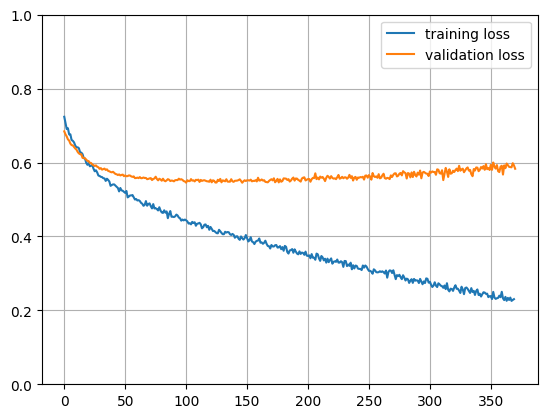

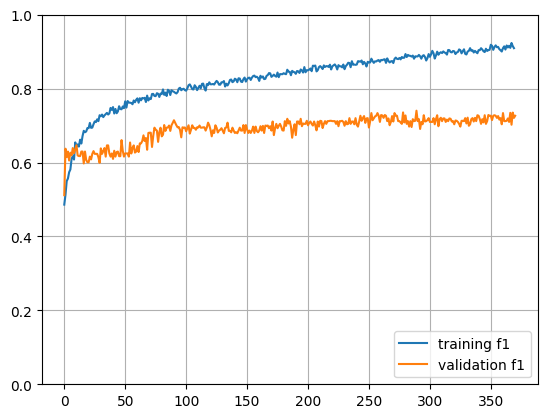

In [53]:
import matplotlib.pyplot as plt
train_loss, train_acc, train_f1, validation_loss, validation_acc, val_f1, test_acc, test_f1 = my_train_test(modelClassifier,
                                                                                              optimizer,
                                                                                              train_dataset,
                                                                                              val_dataset,
                                                                                              test_dataset,
                                                                                              criterion,
                                                                                              hyperparameters["epochs"],
                                                                                              hyperparameters["num_layer_hidden"],
                                                                                              early_stopping)

print("\n---------------\n")
print(f"Test Accuracy: {test_acc}\n")
print(f"Test F1: {test_f1}")
print("\n---------------\n")

#Loss
plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend(loc='upper right')
plt.ylim(0,1)
plt.grid(True)
plt.show()

#F1
plt.plot(train_f1, label='training f1')
plt.plot(val_f1, label='validation f1')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.grid(True)
plt.show()

# Subtask A: Fase di Test per la challenge

In [ ]:
df_test = pd.read_csv(root+"data/subtaskA_test.csv")

nella classe **MyDataset_test** viene implementato un dataset personalizzato per il testing di un modello, organizzando il testo fornito, calcolando i rapporti delle maiuscole, generando gli embeddings

In [ ]:
class MyDataset_test(torch.utils.data.Dataset):

  def __init__(self, x, stopwords):
    #rimuovo ritorni a capo
    x = [text.replace('\n\n', '').replace('\n', '').replace('\r', '') for text in tqdm(x, desc='Remove ritorno a capo ...')]

    # rimuovo le stopwords se sono presenti
    if stopwords:
      text_clean = []
      for sentence in tqdm(x, desc='Remove StopWord ... '):
        sentence = remove_stopwords(sentence)
        text_clean.append(sentence)
    else:
      text_clean = x

    # Conto il numero di uppercase e normalizzo il valore per la lunghezza della frase
    num_uppercase = []
    for sentence in tqdm(text_clean, desc="Count UpperCase ... "):
      count_words_ = count_words(sentence)
      count_uppercase_words_ = count_uppercase_words(sentence)

      if(count_words_ != 0 and count_words_ >= count_uppercase_words_):
        num_uppercase.append(count_uppercase_words_ / count_words_)
      else:
        num_uppercase.append(0)

    # genero gli embeddings
    embeddings_list = []
    for text in tqdm(text_clean, desc='Generation Embeddings ...'):
      tokens = tokenizer([text], add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 512, truncation=True)
      input_id_texts = tokens['input_ids'].squeeze(1).to(device)
      mask_texts = tokens['attention_mask'].squeeze(1).to(device)
      embeddings_list.append(gen_embeddings(input_id_texts, mask_texts))


    self.embeddings = embeddings_list
    self.uppercase_ratio = [torch.tensor([i]) for i in num_uppercase]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.embeddings[idx],  self.uppercase_ratio[idx]

In [ ]:
test = df_test['comment_text']

In [ ]:
dataset = MyDataset_test(test.values, hyperparameters["stopwords"])

Generation Embeddings ...: 100%|██████████| 460/460 [00:15<00:00, 29.92it/s]


La funzione **prediction_test** effettua la predizione del modello su un dataset di test.  
La funzione generare le predizioni del modello su un dataset di test e restituisce ulteriori valutazioni o analisi

In [ ]:
def prediction_test(model, dataset, num_layer_hidden):
  #imposto il modello in modalità di valutazione
  model.eval()

  all_predictions = []

  with torch.no_grad():
    for data_inputs, data_uppercase in dataset:

      # 1. Sposto i dati di input sul dispositivo
      data_inputs = data_inputs.unsqueeze(0).to(device)
      data_uppercase = data_uppercase.unsqueeze(0).to(device)

      # 2. Eseguo il modello sui dati di input
      output = model(data_inputs, data_uppercase, num_layer_hidden)
      output = output.squeeze(0)

      # 4. Calcolo accuracy
      predictions = torch.sigmoid(output)
      predictions = (predictions >= 0.5).float()

      # 5: Salva predizioni
      all_predictions.append(predictions)

  return all_predictions

In [ ]:
list_prediction_test = prediction_test(modelClassifier, dataset, 0)

In [ ]:
lista_interi = [int(tensor.item()) for tensor in list_prediction_test]

viene generato il file .csv contenente i risultati da passare a kaggle per fare la submission

In [ ]:
#Impostazione del percorso del nuovo file CSV
percorso_file_output = root + "data/output_testA2.csv"

In [ ]:
import csv

# Salva la lista come file CSV
with open(percorso_file_output, 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["id", "Expected"])
  writer.writerows([[i, valore] for i, valore in enumerate(lista_interi)])